In [3]:
import zipfile
import os

# Define the file path
zip_path = "/content/030117_053117_Data.zip"
extract_path = "/content/extracted_files"

# Create an extraction folder (optional)
os.makedirs(extract_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Files extracted to:", extract_path)

Files extracted to: /content/extracted_files


In [4]:
import os

# List the extracted files
for root, dirs, files in os.walk(extract_path):
    for file in files:
        print(os.path.join(root, file))

/content/extracted_files/PPB Data/NIJ2017_FEB27.sbn
/content/extracted_files/PPB Data/NIJ2017_JAN01_JAN31.sbn
/content/extracted_files/PPB Data/NIJ2017_FEB28.prj
/content/extracted_files/PPB Data/NIJ2017_MAR01_MAYR31.xlsx
/content/extracted_files/PPB Data/NIJ2017_FEB27.sbx
/content/extracted_files/PPB Data/NIJ2017_MAR01_MAR31.cpg
/content/extracted_files/PPB Data/NIJ2017_FEB15_FEB21.dbf
/content/extracted_files/PPB Data/NIJ2017_FEB15_FEB21.shp
/content/extracted_files/PPB Data/NIJ2017_MAR01_MAR31.dbf
/content/extracted_files/PPB Data/NIJ2017_MAR01_MAR31.sbx
/content/extracted_files/PPB Data/NIJ2017_FEB22_FEB26.dbf
/content/extracted_files/PPB Data/NIJ2017_MAR01_MAR31.shx
/content/extracted_files/PPB Data/NIJ2017_FEB28.dbf
/content/extracted_files/PPB Data/NIJ2017_MAR01_MAR31.sbn
/content/extracted_files/PPB Data/NIJ2017_FEB01_FEB14.sbn
/content/extracted_files/PPB Data/NIJ2017_FEB15_FEB21.sbx
/content/extracted_files/PPB Data/NIJ2017_JAN01_JAN31.sbx
/content/extracted_files/PPB Data/NI

** 2. Data Analysis and Preprocessing**

In [5]:
import pandas as pd

# Define the correct path to the Excel file
dataset_path = os.path.join(extract_path, "PPB Data", "NIJ2017_MAR01_MAYR31.xlsx")

# Load the Excel file
data = pd.read_excel(dataset_path)

# Display basic info
print("Dataset Head:")
print(data.head())
print("\nDataset Info:")
data.info()

Dataset Head:
        CATEGORY CALL GROUPS final_case_type  \
0  STREET CRIMES    DISORDER          DISTP    
1  STREET CRIMES    DISORDER          DISTP    
2  STREET CRIMES    DISORDER          DISTP    
3  STREET CRIMES    DISORDER          DISTP    
4  STREET CRIMES    DISORDER          DISTP    

                                           CASE DESC   occ_date  x_coordinate  \
0  DISTURBANCE - PRIORITY                        ... 2017-03-01       7636989   
1  DISTURBANCE - PRIORITY                        ... 2017-03-01       7642678   
2  DISTURBANCE - PRIORITY                        ... 2017-03-01       7644487   
3  DISTURBANCE - PRIORITY                        ... 2017-03-01       7644536   
4  DISTURBANCE - PRIORITY                        ... 2017-03-01       7649094   

   y_coordinate  census_tract  
0        692809        4300.0  
1        671992        5900.0  
2        685933        5100.0  
3        699871        3803.0  
4        688574        2303.0  

Dataset Info:
<cl

**2. Model Development: Feature Engineering, split data, train model and evaluate model**

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Copy data to ensure original remains intact
df = data.copy()

# Extract temporal features (skip 'occ_date' as it's already processed)
df['Year'] = df['occ_date'].dt.year
df['Month'] = df['occ_date'].dt.month
df['Day'] = df['occ_date'].dt.day
df['Weekday'] = df['occ_date'].dt.weekday
df['Hour'] = df['occ_date'].dt.hour  # If time data exists in another column, adjust this

# Handle missing values (e.g., census_tract)
df['census_tract'].fillna(-1, inplace=True)

# Create a binary target: "Hotspot" or "Not Hotspot"
# Define a hotspot if the occurrence count of crimes in a census tract exceeds a threshold
threshold = 10  # Example threshold
df['crime_count'] = df.groupby('census_tract')['census_tract'].transform('count')
df['is_hotspot'] = (df['crime_count'] > threshold).astype(int)

# Drop irrelevant columns for training (occ_date is not needed anymore)
df.drop(['crime_count', 'CASE DESC'], axis=1, inplace=True)

# Features and target variable
features = ['x_coordinate', 'y_coordinate', 'census_tract', 'Year', 'Month', 'Day', 'Weekday']
target = 'is_hotspot'

# Split the dataset
X = df[features]
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


<ipython-input-6-0abfabaf6f62>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['census_tract'].fillna(-1, inplace=True)


Accuracy: 0.9996420581655481

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80        12
           1       1.00      1.00      1.00     11163

    accuracy                           1.00     11175
   macro avg       1.00      0.83      0.90     11175
weighted avg       1.00      1.00      1.00     11175



**Calculate PAI**

In [11]:
# Predict on the test set
y_pred_test = model.predict(X_test)
# True Positives (TP), True Negatives (TN), False Positives (FP), False Negatives (FN)
TP = np.sum((y_test == 1) & (y_pred_test == 1))
TN = np.sum((y_test == 0) & (y_pred_test == 0))
FP = np.sum((y_test == 0) & (y_pred_test == 1))
FN = np.sum((y_test == 1) & (y_pred_test == 0))

# Calculate Prediction Accuracy Index (PAI)
PAI = (TP + TN) / len(y_test)
print(f"Prediction Accuracy Index (PAI): {PAI}")

Prediction Accuracy Index (PAI): 0.9996420581655481


**Calculate PEI**

In [12]:
# Calculate Prediction Efficiency Index (PEI)
PEI = TP / (TP + FP)
print(f"Prediction Efficiency Index (PEI): {PEI}")

Prediction Efficiency Index (PEI): 0.9996418017372616


**3. Forecast Hotspots**

In [8]:
# Simulate two weeks' data for forecasting (update with actual logic)
future_dates = pd.date_range(start='2017-06-01', end='2017-06-14', freq='D')
future_data = pd.DataFrame({
    'Year': [2017] * len(future_dates),
    'Month': future_dates.month,
    'Day': future_dates.day,
    'Weekday': future_dates.weekday,
    'x_coordinate': np.random.randint(df['x_coordinate'].min(), df['x_coordinate'].max(), len(future_dates)),
    'y_coordinate': np.random.randint(df['y_coordinate'].min(), df['y_coordinate'].max(), len(future_dates)),
    'census_tract': np.random.choice(df['census_tract'].unique(), len(future_dates))
})
# Predict hotspots
future_data['is_hotspot'] = model.predict(future_data[features])
print("Forecasted Hotspots:")
print(future_data[future_data['is_hotspot'] == 1])

Forecasted Hotspots:
    Year  Month  Day  Weekday  x_coordinate  y_coordinate  census_tract  \
1   2017      6    2        4       7651605        727657        9604.0   
2   2017      6    3        5       7633260        698158        1802.0   
3   2017      6    4        6       7625194        648457       30502.0   
5   2017      6    6        1       7657538        728458        3702.0   
7   2017      6    8        3       7685404        744241         601.0   
8   2017      6    9        4       7693200        736686        7000.0   
10  2017      6   11        6       7675489        654576        3501.0   
11  2017      6   12        0       7605016        698575        8302.0   
12  2017      6   13        1       7658011        645568        1202.0   
13  2017      6   14        2       7630963        650000        6702.0   

    is_hotspot  
1            1  
2            1  
3            1  
5            1  
7            1  
8            1  
10           1  
11           1  


**4. Visualize Hotspots**

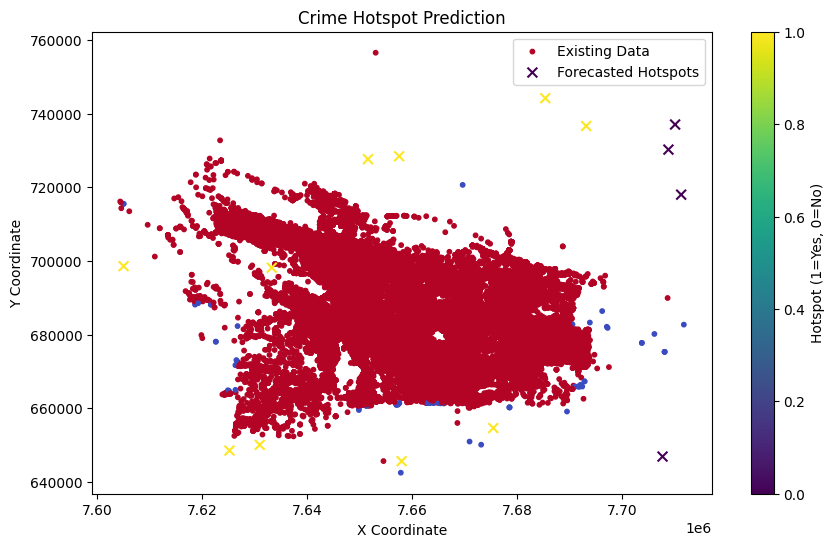

In [9]:
# Visualization of predicted hotspots
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(df['x_coordinate'], df['y_coordinate'], c=df['is_hotspot'], cmap='coolwarm', s=10, label="Existing Data")
plt.scatter(future_data['x_coordinate'], future_data['y_coordinate'], c=future_data['is_hotspot'], cmap='viridis', s=50, marker='x', label="Forecasted Hotspots")
plt.colorbar(label="Hotspot (1=Yes, 0=No)")
plt.title("Crime Hotspot Prediction")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()
plt.show()

**Confusion Matrix for Model Evaluation**

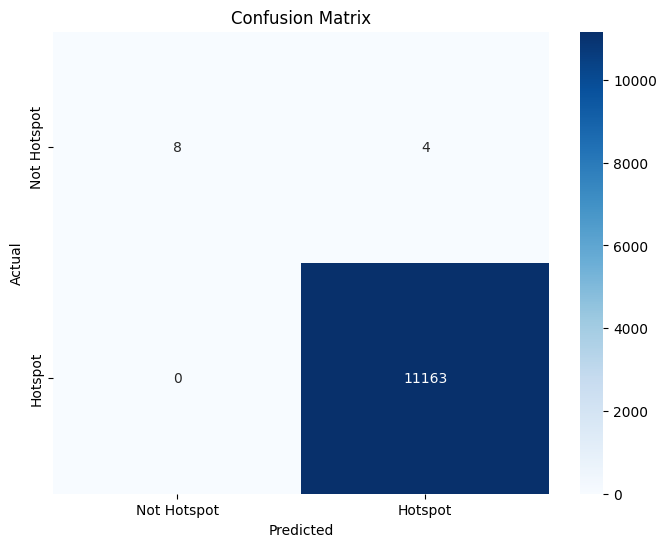

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Hotspot', 'Hotspot'], yticklabels=['Not Hotspot', 'Hotspot'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**Temporal Distribution of crimes**

**Number of crimes over time**

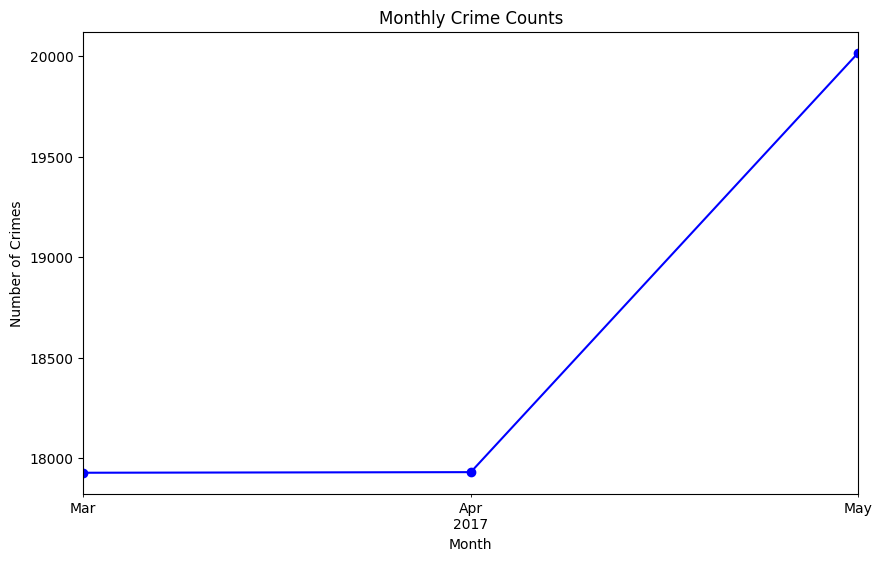

In [13]:
# Crimes per month
crime_per_month = df.groupby(df['occ_date'].dt.to_period('M')).size()

plt.figure(figsize=(10, 6))
crime_per_month.plot(kind='line', color='blue', marker='o')
plt.title("Monthly Crime Counts")
plt.xlabel("Month")
plt.ylabel("Number of Crimes")
plt.xticks(rotation=45)
plt.show()

**Temporal Distribution of Crimes per Day in May**

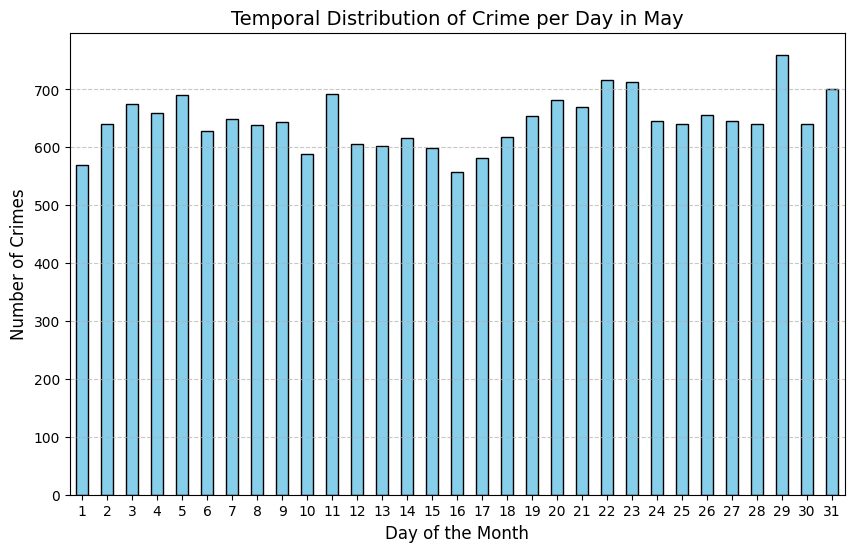

In [26]:
import matplotlib.pyplot as plt

# Filter the dataset for the month of May
df_may = df[df['Month'] == 5]

# Group by the day of the month and count the number of crimes for each day
crime_per_day = df_may.groupby('Day').size()

# Plot the temporal distribution
plt.figure(figsize=(10, 6))
crime_per_day.plot(kind='bar', color='skyblue', edgecolor='black')

# Customize the plot
plt.title('Temporal Distribution of Crime per Day in May', fontsize=14)
plt.xlabel('Day of the Month', fontsize=12)
plt.ylabel('Number of Crimes', fontsize=12)
plt.xticks(rotation=0)  # To keep day labels readable
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**2. Geospatial Distribution of Crimes**

**Crime Locations Scatter Plot**

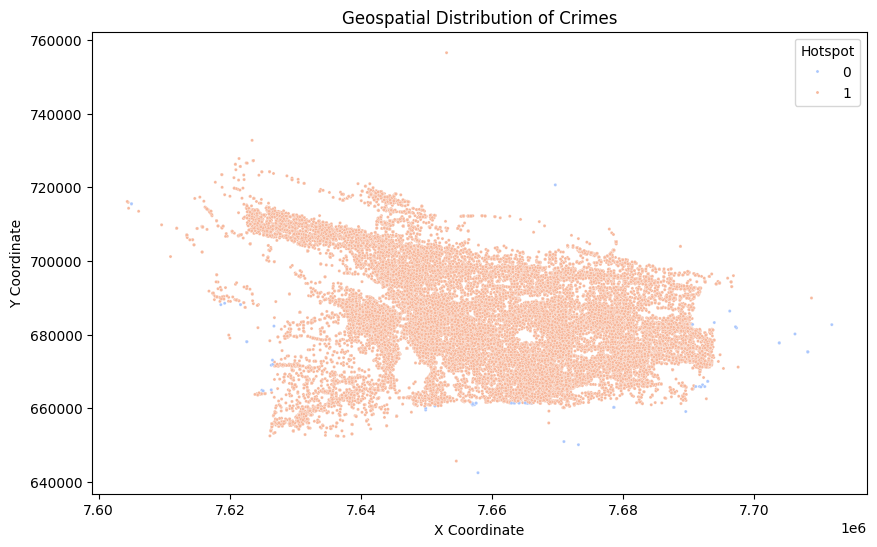

In [15]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x='x_coordinate', y='y_coordinate', data=df, hue='is_hotspot', palette='coolwarm', s=5)
plt.title("Geospatial Distribution of Crimes")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend(title="Hotspot", loc='upper right')
plt.show()

**Model performance over time**

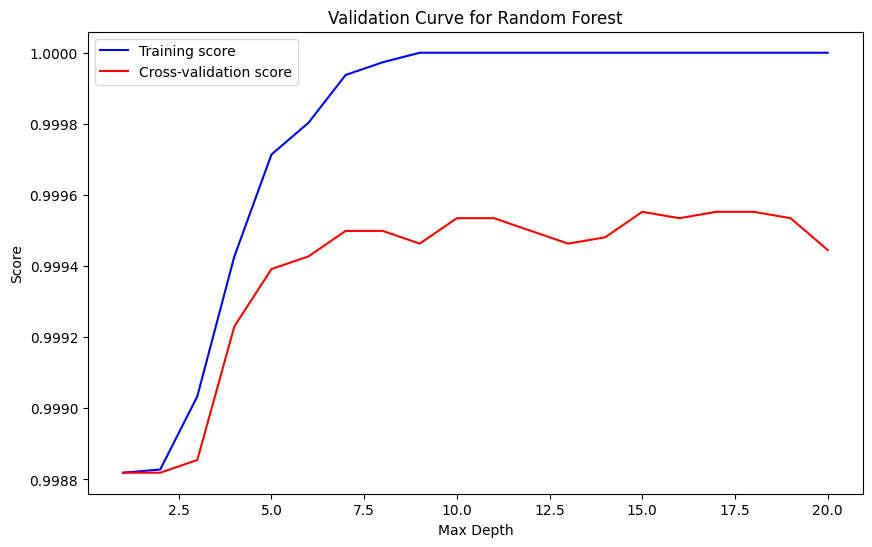

In [18]:
from sklearn.model_selection import validation_curve

# We can split the data by time periods (e.g., by month)
df['Month'] = df['occ_date'].dt.month

# Compute validation curve for Random Forest based on different month periods
train_scores, test_scores = validation_curve(
    RandomForestClassifier(n_estimators=100),
    X, y,
    param_name="max_depth", param_range=np.arange(1, 21),
    cv=3, scoring="accuracy"
)

# Plot the validation curve
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, 21), np.mean(train_scores, axis=1), label="Training score", color="blue")
plt.plot(np.arange(1, 21), np.mean(test_scores, axis=1), label="Cross-validation score", color="red")
plt.xlabel("Max Depth")
plt.ylabel("Score")
plt.title("Validation Curve for Random Forest")
plt.legend()
plt.show()